In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
%load_ext autoreload
%autoreload 2

Set up training data

In the next cell, we set up the training data for this example. We’ll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
filename = "/Users/litz/Documents/GitHub/learning_GPyTorch/simple_grid_test.csv"
df = pd.read_csv(filename, index_col=None, header=0)
dfu = df.ix[df["nu_0_10"]>0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


True

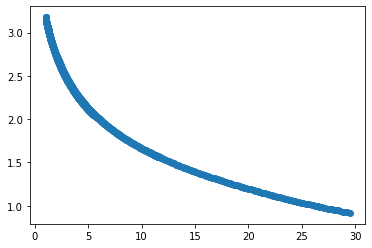

In [3]:
#mean_density =dfu["initial_mass"]/dfu["radius"]**3
#train_x = torch.tensor(list(mean_density))
train_x = torch.tensor(list(dfu["radius"]))
train_y = torch.tensor(list(np.log10(dfu["nu_0_10"])))
plt.scatter(train_x, train_y)
torch.is_tensor(train_x)
torch.is_tensor(train_y)

Setting up the model

The next cell demonstrates the most critical features of a user-defined Gaussian process model in GPyTorch. Building a GP model in GPyTorch is different in a number of ways.

First in contrast to many existing GP packages, we do not provide full GP models for the user. Rather, we provide the tools necessary to quickly construct one. This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary. As can be seen in more complicated examples, this allows the user great flexibility in designing custom models.

For most GP regression models, you will need to construct the following GPyTorch objects:

A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.
A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.
A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)
A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).
A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.
The GP Model

The components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:

An __init__ method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model’s forward method. This will most commonly include things like a mean module and a kernel module.
A forward method that takes in some 𝑛×𝑑 data x and returns a MultivariateNormal with the prior mean and covariance evaluated at x. In other words, we return the vector 𝜇(𝑥) and the 𝑛×𝑛 matrix 𝐾𝑥𝑥 representing the prior mean and covariance matrix of the GP.
This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

self.covar_module = ScaleKernel(RBFKernel() + WhiteNoiseKernel())

Or you can add the outputs of the kernel in the forward method:

covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Model modes

Like most PyTorch modules, the ExactGP has a .train() and .eval() mode. - .train() mode is for optimizing model hyperameters. - .eval() mode is for computing predictions through the model posterior.

Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from torch.optim, and all trainable parameters of the model should be of type torch.nn.Parameter. Because GP models directly extend torch.nn.Module, calls to methods like model.parameters() or model.named_parameters() function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

Zero all parameter gradients
Call the model and compute the loss
Call backward on the loss to fill in gradients
Take a step on the optimizer
However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

In [5]:
def model_run(step = None):
    # this is for running the notebook in our testing framework
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else step


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter): 
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    return

In [6]:
model_run(step = 50)

Iter 1/50 - Loss: 0.803   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.756   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.723   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.678   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 0.637   lengthscale: 0.911   noise: 0.513
Iter 6/50 - Loss: 0.600   lengthscale: 0.970   noise: 0.474
Iter 7/50 - Loss: 0.555   lengthscale: 1.030   noise: 0.437
Iter 8/50 - Loss: 0.506   lengthscale: 1.092   noise: 0.403
Iter 9/50 - Loss: 0.471   lengthscale: 1.154   noise: 0.370
Iter 10/50 - Loss: 0.421   lengthscale: 1.218   noise: 0.340
Iter 11/50 - Loss: 0.387   lengthscale: 1.281   noise: 0.312
Iter 12/50 - Loss: 0.337   lengthscale: 1.344   noise: 0.286
Iter 13/50 - Loss: 0.290   lengthscale: 1.408   noise: 0.261
Iter 14/50 - Loss: 0.245   lengthscale: 1.473   noise: 0.239
Iter 15/50 - Loss: 0.193   lengthscale: 1.538   noise: 0.218
Iter 16/50 - Loss: 0.155   lengthscale: 1.602   noise: 0.198
Iter 17/50 - Loss: 0.098   length

Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a MultivariateNormal containing the prior mean and covariance from forward, a trained GP model in eval mode returns a MultivariateNormal containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

The gpytorch.settings.fast_pred_var context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using LOVE.

Plot the model fit

In the next cell, we plot the mean and confidence region of the Gaussian process model. The confidence_region method is a helper method that returns 2 standard deviations above and below the mean.

//anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:282: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


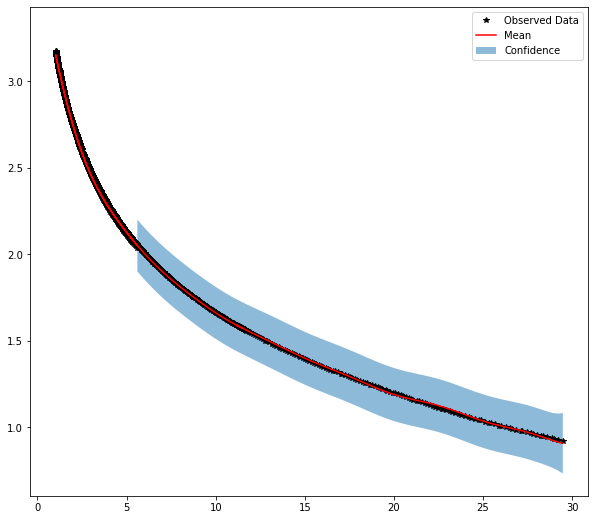

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


In [ ]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])



In [ ]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])




In [ ]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])




In [ ]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])